In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.dm import DataModule2 as DataModule
from src.models.unet_ltae import UNetLTAE
from src.models.unet_df import UNetDF2

In [3]:
import torch 

checkpoint = [
    ('checkpoints/dfta_oc-val_metric=29.47327-epoch=368.ckpt', UNetLTAE, {
        'encoder': 'resnet18',
        'pretrained': 'imagenet',
        'in_channels_s1': 2,
        'in_channels_s2': 6,
        'seq_len': 12,
        'n_head': 16,
    }),
    #     ('checkpoints/dftar50-val_metric=29.42491-epoch=277.ckpt', UNetLTAE, {
    #     'encoder': 'timm-resnest50d',
    #     'pretrained': 'imagenet',
    #     'in_channels_s1': 2,
    #     'in_channels_s2': 6,
    #     'seq_len': 12,
    #     'n_head': 16,
    # }),
    ('checkpoints/dft2_oc-val_metric=29.71048-epoch=431.ckpt', UNetDF2, {
        'encoder': 'resnet18',
        'pretrained': 'imagenet',
        'in_channels_s1': 2,
        'in_channels_s2': 6,
        'seq_len': 12,
    })
]

In [4]:
dm = DataModule(val_size=0.2, num_workers=10, pin_memory=True, batch_size=4)
dm.setup()

train: 6951
val: 1738
test: 2773


In [5]:
class Identity:
    def __call__(self, x):
        return x

class Rot90:
    def __init__(self, axes=(2, 3)):
        self.axes = axes
    def __call__(self, x):
        return torch.rot90(x, 1, self.axes)

class Rot180:
    def __init__(self, axes=(2, 3)):
        self.axes = axes
    def __call__(self, x):
        return torch.rot90(x, 2, self.axes)

class Rot270:
    def __init__(self, axes=(2, 3)):
        self.axes = axes
    def __call__(self, x):
        return torch.rot90(x, 3, self.axes)

class Flip:
    def __init__(self, axis=2):
        self.axis = axis
    def __call__(self, x):
        return torch.flip(x, [self.axis])

class Transpose:
    def __init__(self, axes=(2, 3)):
        self.axes = axes
    def __call__(self, x):
        return torch.transpose(x, self.axes[0], self.axes[1])

trans = [
    (Identity(), Identity()),
    (Rot90(), Rot270()),
    (Rot180(), Rot180()),
    (Rot270(), Rot90()),
    (Flip(2), Flip(2)),
    (Flip(3), Flip(3)),
    (Transpose(), Transpose()),
]

In [6]:
from tqdm import tqdm 

trans = [
    (Identity(), Identity()),
    (Rot90(), Rot270(axes=(1, 2))),
    (Rot180(), Rot180(axes=(1, 2))),
    (Rot270(), Rot90(axes=(1, 2))),
    (Flip(2), Flip(1)),
    (Flip(3), Flip(2)),
    (Transpose(), Transpose(axes=(1, 2))),
]

dl = dm.val_dataloader(batch_size=4, shuffle=False)
s1, s2, labels = next(iter(dl))

mpreds = []
for ckpt, Module, hparams in checkpoint:
    state_dict = torch.load(ckpt)['state_dict']
    module = Module(hparams)
    module.load_state_dict(state_dict)
    module.cuda(1)
    metrics = []
    bpreds, ys = [], []
    for batch in tqdm(dl):
        x1, x2, y = batch
        ys += [y]
        s1, s2 = x1.cuda(1), x2.cuda(1)
        preds = []
        for t1, t2 in trans:
            preds.append(t2(module.predict(t1(s1), t1(s2))))
        preds = torch.stack(preds).mean(0).cpu()
        bpreds += [preds]
    bpreds = torch.cat(bpreds)
    mpreds += [bpreds]
mpreds = torch.stack(mpreds).mean(0)
ys = torch.cat(ys)
torch.mean(torch.sqrt(torch.mean((mpreds * 12905.3 - ys * 12905.3)**2, dim=(1, 2)))).item()

100%|██████████| 435/435 [02:23<00:00,  3.03it/s]


28.655288696289062

In [37]:
from tqdm import tqdm 
from skimage.io import imsave

dl = dm.test_dataloader(batch_size=4)

trans = [
    (Identity(), Identity()),
    (Rot90(), Rot270(axes=(1, 2))),
    (Rot180(), Rot180(axes=(1, 2))),
    (Rot270(), Rot90(axes=(1, 2))),
    (Flip(2), Flip(1)),
    (Flip(3), Flip(2)),
    (Transpose(), Transpose(axes=(1, 2))),
]

mpreds = []
for chkpt, Module, hparams in checkpoint:
	state_dict = torch.load(chkpt)['state_dict']
	module = Module(hparams)
	module.load_state_dict(state_dict)
	module.cuda(1)
	bpreds, ys = [], []
	for s1, s2, chip_ids in tqdm(dl):
		s1, s2 = s1.cuda(1), s2.cuda(1)
		ys += chip_ids
		preds = []
		for t1, t2 in trans:
			preds.append(t2(module.predict(t1(s1), t1(s2))))
		preds = torch.stack(preds).mean(0).cpu()
		preds = preds * 12905.3
		bpreds += [preds]
	bpreds = torch.cat(bpreds)
	mpreds += [bpreds]
mpreds = torch.stack(mpreds).mean(0)

for chip_id, pred in zip(ys, mpreds):
	imsave(f'./submission/{chip_id}_agbm.tif', pred.numpy())

4it [00:01,  2.13it/s]
4it [00:02,  1.91it/s]


In [28]:
import glob 

files = glob.glob('./submission/*.tif')
assert len(files) == 2773

In [29]:
# zip folder 

import shutil
shutil.make_archive('submission', 'zip', './submission')

'/home/juan/Desktop/competis/TheBioMassters/submission.zip'

In [30]:
import rasterio as rio
import numpy as np

ix = np.random.randint(0, len(files))
ds = rio.open(files[ix])

ds.indexes, ds.shape, ds.count

/home/juan/miniconda3/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


((1,), (256, 256), 1)

In [31]:
x = ds.read(1)

x.shape, x.dtype, x.min(), x.max()

((256, 256), dtype('float32'), 8.576973e-09, 329.09583)

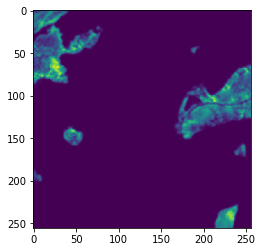

In [34]:
import matplotlib.pyplot as plt

plt.imshow(x)
plt.show()